## Hackathon 3 : Sentiment Classification  - JUST EDA

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker


from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from autocorrect import Speller
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#Stemmmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer

#Lemmatization
from nltk.stem import WordNetLemmatizer


import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [26]:
# Import the wordcloud library
from wordcloud import WordCloud


In [2]:
traindf = pd.read_csv("train.csv")
#testdf = pd.read_csv("test.csv")

In [3]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

In [6]:
def getSentimentName(number):
    if number == 0:
        return 'Negative'
    if number == 1:
        return 'Neutral'
    if number == 2:
        return 'Positive'
    if number == 3:
        return 'Cant Tell'
    

In [7]:
traindf['sentiment_name'] = traindf['sentiment'].apply(lambda x: getSentimentName(x))

In [8]:
traindf.head()

tweet_id                                              tweet  sentiment  \
0      1701  #sxswnui #sxsw #apple defining language of tou...          1   
1      1851  Learning ab Google doodles! All doodles should...          1   
2      2689  one of the most in-your-face ex. of stealing t...          2   
3      4525  This iPhone #SXSW app would b pretty awesome i...          0   
4      3604  Line outside the Apple store in Austin waiting...          1   

  sentiment_name  
0        Neutral  
1        Neutral  
2       Positive  
3       Negative  
4        Neutral

In [12]:
temp = traindf.groupby('sentiment_name').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp

sentiment_name  tweet
2        Neutral   4310
3       Positive   2382
1       Negative    456
0      Cant Tell    125

Text(0.5, 1.0, 'Counts of Different Sentiments')

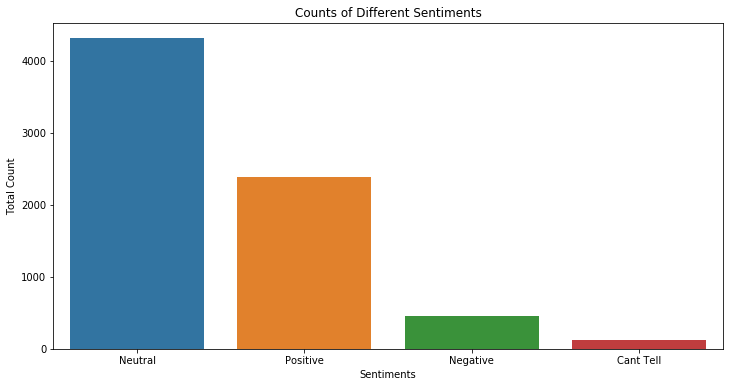

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment_name',data=traindf)
plt.xlabel("Sentiments")
plt.ylabel("Total Count")
plt.title("Counts of Different Sentiments")

In [23]:
# convert column type to string
traindf['tweet'] = traindf['tweet'].astype(str)
    
    
# to lower case
traindf['tweet'] = traindf['tweet'].apply(lambda x: x.lower())
    
#removing @mention
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
#removing @handles , since trending tweets are on Hashtags
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
#removing Http links , since trending tweets are on Hashtags
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
#converting emoticon
#traindf['tweet']= traindf['tweet'].apply(lambda x: convert_emoticons(x))
    
#handling apostrophe
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub("’", "'",x))
       
# remove numbers
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

# remove punctuations and convert characters to lower case
traindf['tweet'] = traindf['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
#converting Html Encoding
html_parser = HTMLParser()
traindf['tweet']= traindf['tweet'].apply(lambda x: html_parser.unescape(x))
    
#removing #HashTags 
#df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
# #removing '#' symbol 
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
#replacing double whitespace with single 
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub(' +', ' ',x))

#Removing RT
traindf['tweet']= traindf['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



### Getting Positive Tweet

In [24]:
PositiveTweetsBeforeStopWords = traindf[traindf['sentiment_name']=='Positive']

In [25]:
PositiveTweetsBeforeStopWords.head()

tweet_id                                              tweet  sentiment  \
2       2689  one of the most inyourface ex of stealing the ...          2   
8       8835         free sxsw sampler on itunes link freemusic          2   
9        883  i think i might go all weekend without seeing ...          2   
11      2369        its official im buying an ipad sxsw elevate          2   
12      3944  theyre giving away ipad s x boxes and books at...          2   

   sentiment_name  
2        Positive  
8        Positive  
9        Positive  
11       Positive  
12       Positive

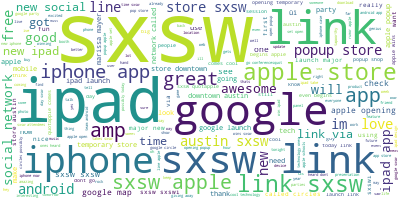

In [27]:


# Join the different processed jobs together.

long_string = ','.join(list(PositiveTweetsBeforeStopWords['tweet'].values))
                            
#stop_words = set(stopwords.words('english'))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


### Getting Negative Tweet

In [28]:
NegativeTweetsBeforeStopWords = traindf[traindf['sentiment_name']=='Negative']

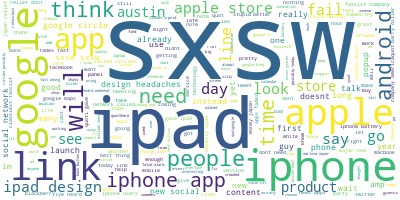

In [29]:


# Join the different processed jobs together.

long_string = ','.join(list(NegativeTweetsBeforeStopWords['tweet'].values))
                            
#stop_words = set(stopwords.words('english'))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


### Removing Stop-Words and Checking

In [30]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
stop_words = all_stopwords
traindf['tweet'] =  traindf['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

### PostiveTweet After StopWords

In [31]:
PositiveTweetsAfterStopWords = traindf[traindf['sentiment_name']=='Positive']

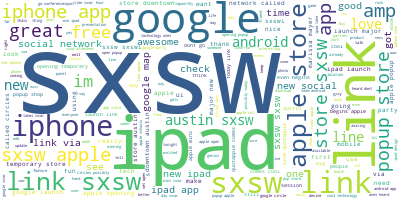

In [34]:


# Join the different processed jobs together.

long_string = ','.join(list(PositiveTweetsAfterStopWords['tweet'].values))
                            
#stop_words = set(stopwords.words('english'))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


### NegativeTweet After StopWords Removal

In [32]:
NegativeTweetsAfterStopWords = traindf[traindf['sentiment_name']=='Negative']

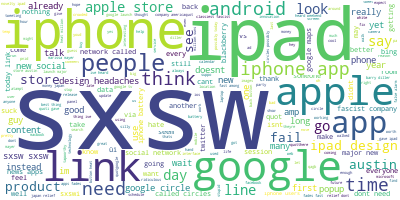

In [33]:


# Join the different processed jobs together.

long_string = ','.join(list(NegativeTweetsAfterStopWords['tweet'].values))
                            
#stop_words = set(stopwords.words('english'))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


### Something on HashTags

In [42]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [60]:
traindf1= pd.read_csv("train.csv")



In [61]:
traindf1['sentiment_name'] = traindf1['sentiment'].apply(lambda x: getSentimentName(x))

In [66]:
traindf1['tweet'] = traindf1['tweet'].astype(str)
traindf1['tweet'] = traindf1['tweet'].apply(lambda x: x.lower())

In [67]:
traindf1.head()

tweet_id                                              tweet  sentiment  \
0      1701  #sxswnui #sxsw #apple defining language of tou...          1   
1      1851  learning ab google doodles! all doodles should...          1   
2      2689  one of the most in-your-face ex. of stealing t...          2   
3      4525  this iphone #sxsw app would b pretty awesome i...          0   
4      3604  line outside the apple store in austin waiting...          1   

  sentiment_name  
0        Neutral  
1        Neutral  
2       Positive  
3       Negative  
4        Neutral

In [68]:
traindf1[traindf1['sentiment_name']=='Positive']['tweet']

2       one of the most in-your-face ex. of stealing t...
8          free #sxsw sampler on itunes {link} #freemusic
9       i think i might go all weekend without seeing ...
11      it's official! i'm buying an ipad. #sxsw #elevate
12      they're giving away ipad 2's, x boxes and book...
                              ...                        
7261    the new whrrl app is now live in the iphone ap...
7263    there are two apple stores in atx!! rt @mentio...
7265    at #sxsw, apple schools the marketing experts ...
7266    @mention great stuff on fri #sxsw: marissa may...
7268    great visualisation of the ghost movement logi...
Name: tweet, Length: 2382, dtype: object

In [80]:
type(HT_positive)


list

In [81]:
while 'sxsw' in HT_positive:
    HT_positive.remove('sxsw')

while thing in some_list:
    HT_positive.remove('sxswi')


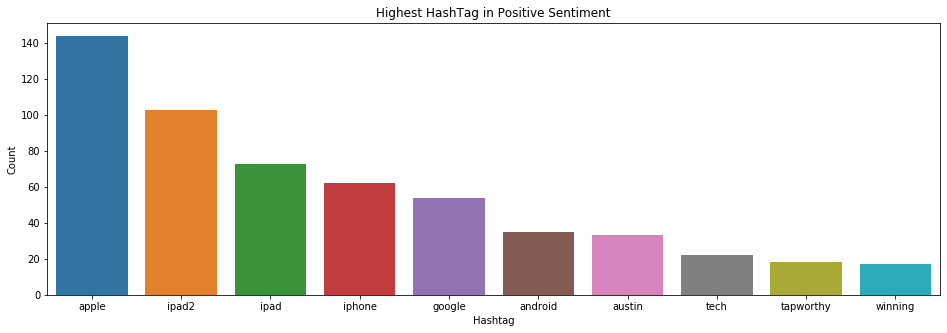

In [85]:
# TOP HASHTAGS IN POSITIVE TWEET

HT_positive = hashtag_extract(traindf1[traindf1['sentiment_name']=='Positive']['tweet'])

HT_positive = sum(HT_positive,[])

while 'sxsw' in HT_positive:
    HT_positive.remove('sxsw')

while 'sxswi' in HT_positive:
    HT_positive.remove('sxswi')

a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Highest HashTag in Positive Sentiment")
plt.show()



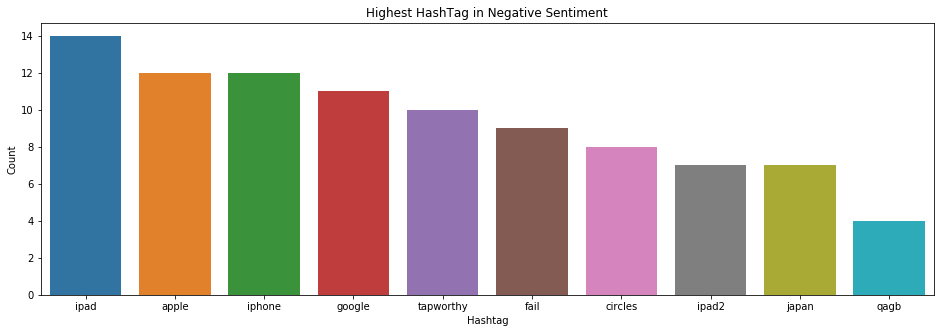

In [86]:
# TOP HASHTAGS IN NEGATIVE TWEET

# extracting hashtags from Negative Hashtags
HT_negative =  hashtag_extract(traindf1[traindf1['sentiment_name']=='Negative']['tweet'])

HT_negative = sum(HT_negative,[])

while 'sxsw' in HT_negative:
    HT_negative.remove('sxsw')

while 'sxswi' in HT_negative:
    HT_negative.remove('sxswi')


a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Highest HashTag in Negative Sentiment")
plt.show()

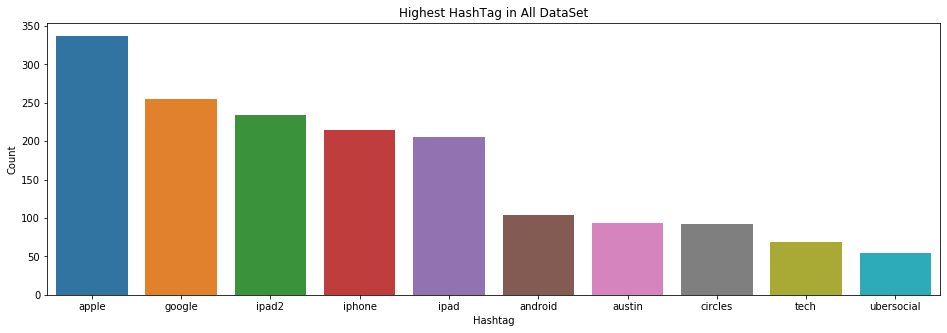

In [88]:
#Highest HashTagged Overall

HT_overall = hashtag_extract(traindf1['tweet'])
HT_overall = sum(HT_overall,[])


while 'sxsw' in HT_overall:
    HT_overall.remove('sxsw')

while 'sxswi' in HT_overall:
    HT_overall.remove('sxswi')


a = nltk.FreqDist(HT_overall)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Highest HashTag in All DataSet")
plt.show()